# Visulization of the OGB-MolPCBA Dataset

## Import Data

In [1]:
import os
import torch
import numpy as np
from ogb.graphproppred import PygGraphPropPredDataset
from ogb.utils.url import download_url

In [2]:
# download  and process the dataset
root_dir = 'data'
ogb_dataset = PygGraphPropPredDataset(name = 'ogbg-molpcba', root = root_dir)
metadata_file_path = os.path.join(ogb_dataset.root, 'raw', 'scaffold_group.npy')
if not os.path.exists(metadata_file_path):
    download_url('https://snap.stanford.edu/ogb/data/misc/ogbg_molpcba/scaffold_group.npy', os.path.join(ogb_dataset.root, 'raw'))

In [3]:
# set variables
data_dir = ogb_dataset.root
split_scheme = 'scaffold'
y_type = 'float' # although the task is binary classification, the prediction target contains nan value, thus we need float
y_size = ogb_dataset.num_tasks
n_classes = ogb_dataset.__num_classes__

In [4]:
# initialize data

# Here ogb_dataset.data is a torch_geometric.data.Data object
# See the docs at https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html?highlight=data.data.Data#torch_geometric.data.Data

# node features
x_array = ogb_dataset.data.x.data.numpy()

# graph connectivity
edge_index_array = ogb_dataset.data.edge_index.data.numpy()

# edge features
edge_attr_array = ogb_dataset.data.edge_attr.data.numpy()

# labels
y_array = ogb_dataset.data.y.data.numpy()

# train/val/test split
split_array = np.zeros(len(ogb_dataset))
split_idx  = ogb_dataset.get_idx_split()
split_array[split_idx['train']] = 0
split_array[split_idx['valid']] = 1
split_array[split_idx['test']] = 2

# scaffold (metadata)
scaffold_array = np.load(metadata_file_path)

# num of nodes in each graph
num_of_nodes_array = np.array(ogb_dataset.data.num_nodes, dtype=np.int64)

# num of edges in each graph
num_of_edges_array = np.genfromtxt('num-edge-list.csv', skip_header=False, dtype=np.int64)

In [5]:
print('Shapes of variables:')
print('x: ', x_array.shape)
print('edge index: ', edge_index_array.shape)
print('edge attributes: ', edge_attr_array.shape)
print('y: ', y_array.shape)
print('split: ', split_array.shape)
print('scaffold: ', scaffold_array.shape)
print('num of nodes: ', num_of_nodes_array.shape)
print('num of edges: ', num_of_edges_array.shape)

Shapes of variables:
x:  (11373137, 9)
edge index:  (2, 24618372)
edge attributes:  (24618372, 3)
y:  (437929, 128)
split:  (437929,)
scaffold:  (437929,)
num of nodes:  (437929,)
num of edges:  (437929,)


In [6]:
print('Heads of these variables:')
print('x: \n', x_array[:5, :])
print('edge index: \n', edge_index_array[:, :5])
print('edge attributes: \n', edge_attr_array[:5, :])
print('y: \n', y_array[:5, :2])
print('split: \n', split_array[:10])
print('scaffold: \n', scaffold_array[:10])
print('num of nodes: \n', num_of_nodes_array[:10])
print('num of edges: \n', num_of_edges_array[:10])

Heads of these variables:
x: 
 [[5 0 4 5 3 0 2 0 0]
 [5 0 3 5 0 0 1 0 0]
 [7 0 1 5 0 0 1 0 0]
 [6 0 3 5 0 0 1 0 1]
 [5 0 4 5 2 0 2 0 1]]
edge index: 
 [[0 1 1 2 1]
 [1 0 2 1 3]]
edge attributes: 
 [[0 0 0]
 [0 0 0]
 [1 0 1]
 [1 0 1]
 [0 0 1]]
y: 
 [[ 0.  0.]
 [ 0.  0.]
 [nan  0.]
 [nan nan]
 [nan nan]]
split: 
 [0. 0. 0. 0. 2. 0. 0. 0. 2. 0.]
scaffold: 
 [ 38222    225      2   1833 120083   2643  16512     29 120082      0]
num of nodes: 
 [20 15 24 24 33 18 18 22 36 16]
num of edges: 
 [22 16 25 27 36 19 20 23 40 16]


## Basic Statistics

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

### Q1: Is the scaffold indices ordered? And what is the distribution of scaffold sizes? 
Try plotting a histogram of scaffold indices, if so, the small indices will appear most

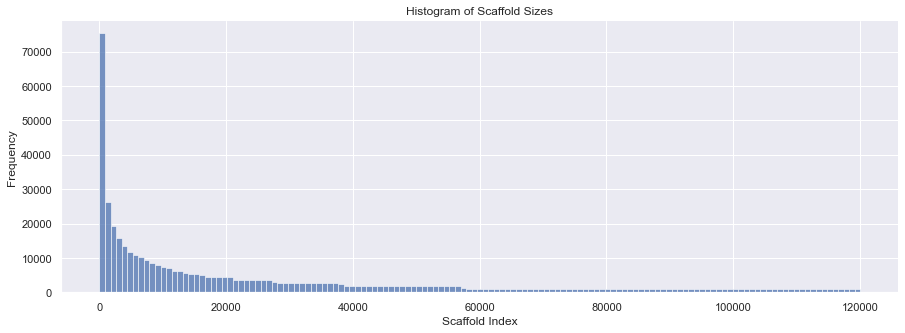

In [8]:
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(scaffold_array)
ax.set_xlabel('Scaffold Index')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Scaffold Sizes')
plt.show()

From the plot above we can see the "exponential distribution" of scaffold sizes

### Q2: What is the distribution of garph sizes? Are the average graph sizes in each scaffold very different?

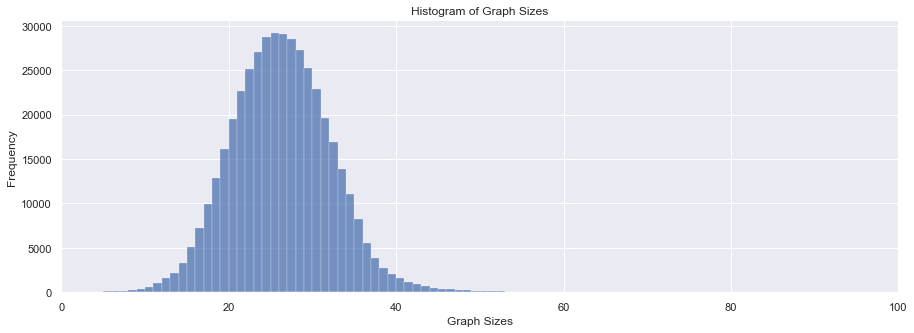

Average number of nodes per graph:  25.970276003644425


In [9]:
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(num_of_nodes_array, binwidth=1)
ax.set_xlabel('Graph Sizes')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Graph Sizes')
ax.set_xlim([0, 100])
plt.show()
print('Average number of nodes per graph: ', np.mean(num_of_nodes_array))

In [10]:
df = pd.DataFrame({'scaffold_idx': scaffold_array, 'graph_size': num_of_nodes_array})
df.groupby('scaffold_idx', as_index=False)['graph_size'].mean().head(10)

,scaffold_idx,graph_size
0,0,18.104604
1,1,15.497175
2,2,22.756585
3,3,23.997653
4,4,16.212682
5,5,18.355628
6,6,17.705373
7,7,17.175983
8,8,16.738318
9,9,18.870712


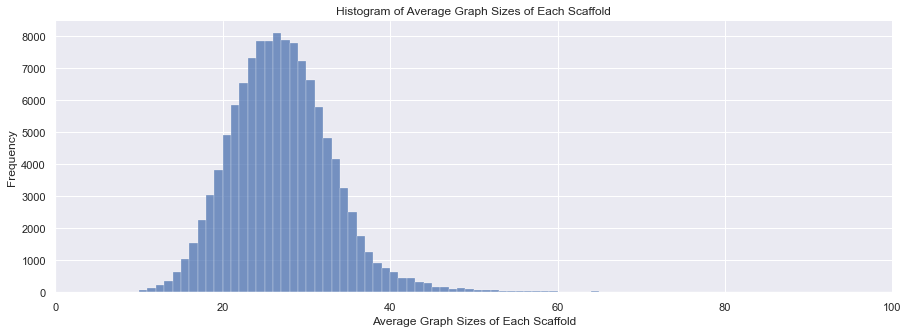

In [11]:
average_sizes_per_scaffold = df.groupby('scaffold_idx')['graph_size'].mean().to_numpy()
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(average_sizes_per_scaffold, binwidth=1)
ax.set_xlabel('Average Graph Sizes of Each Scaffold')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Average Graph Sizes of Each Scaffold')
ax.set_xlim([0, 100])
plt.show()

very minor difference to the original distribution of graph sizes, thus the distribution of graph sizes is almost independent from the scaffold

### Q3: Similarly, what is the distribution of number of edges per graph? Are the average number of edges per graph in each scaffold very different?

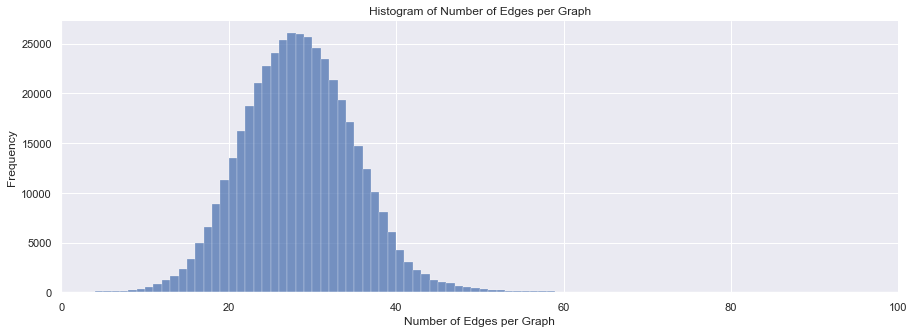

Average number of edges per graph:  28.107720657914868


In [12]:
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(num_of_edges_array, binwidth=1)
ax.set_xlabel('Number of Edges per Graph')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Number of Edges per Graph')
ax.set_xlim([0, 100])
plt.show()
print('Average number of edges per graph: ', np.mean(num_of_edges_array))

In [13]:
df = pd.DataFrame({'scaffold_idx': scaffold_array, 'number_of_edges': num_of_edges_array})
df.groupby('scaffold_idx', as_index=False)['number_of_edges'].mean().head(10)

,scaffold_idx,number_of_edges
0,0,18.102626
1,1,14.448211
2,2,23.756585
3,3,24.997653
4,4,16.211361
5,5,19.352365
6,6,18.696707
7,7,18.175983
8,8,16.733645
9,9,19.854881


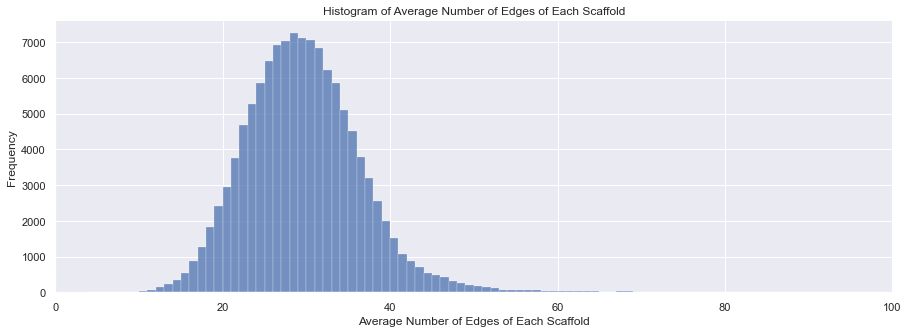

In [14]:
average_nedges_per_scaffold = df.groupby('scaffold_idx')['number_of_edges'].mean().to_numpy()
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(average_nedges_per_scaffold, binwidth=1)
ax.set_xlabel('Average Number of Edges of Each Scaffold')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Average Number of Edges of Each Scaffold')
ax.set_xlim([0, 100])
plt.show()

Note the average size and number of edges matches the numbers on https://ogb.stanford.edu/docs/graphprop/

## Q4: Are the graph size and number of edges strongly correlated? What is the distribution of average degrees?

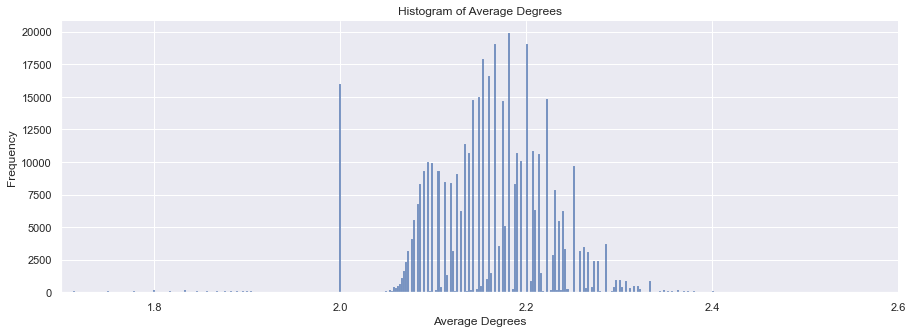

In [15]:
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(num_of_edges_array*2.0/num_of_nodes_array)
ax.set_xlabel('Average Degrees')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Average Degrees')
ax.set_xlim([1.7, 2.6])
plt.show()

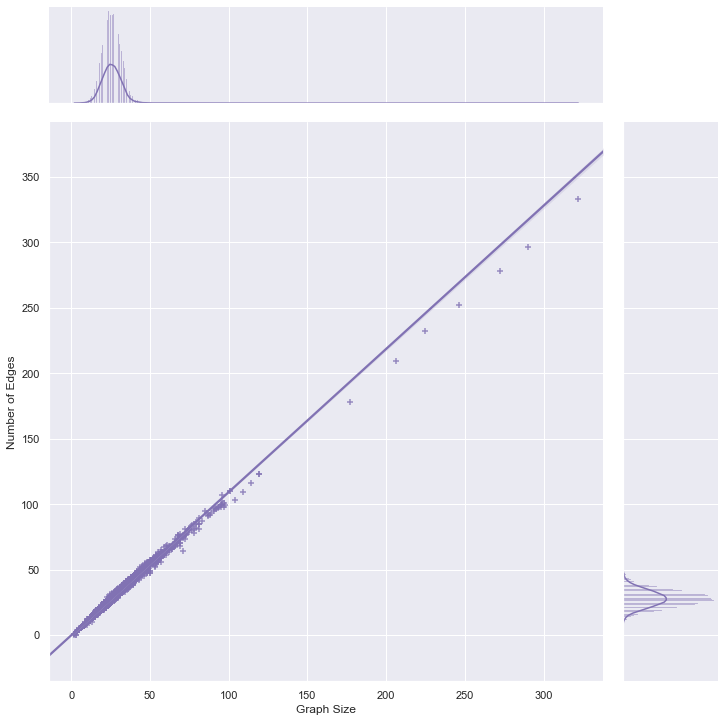

In [16]:
np.random.seed(0)
sample_graph_idx = np.random.choice(num_of_nodes_array.shape[0], 50000, replace=False)
f = sns.jointplot(x=num_of_nodes_array[sample_graph_idx], y=num_of_edges_array[sample_graph_idx], 
              kind="reg", truncate=False, marker='+', color="m", height=10)
f.set_axis_labels('Graph Size', 'Number of Edges')

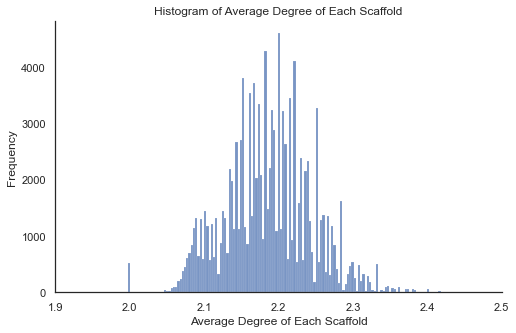

In [53]:
f, ax = plt.subplots(figsize=(8, 5))
sns.despine(f)
sns.histplot(average_nedges_per_scaffold*2.0/average_sizes_per_scaffold)
ax.set_xlabel('Average Degree of Each Scaffold')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Average Degree of Each Scaffold')
ax.set_xlim([1.9, 2.5])
plt.show()

### Generate Subsets of Train/Val/Test

First, understand the original train/val/test split ratios

In [18]:
num_of_train_graphs = np.where(split_array == 0)[0].shape[0]
num_of_val_graphs = np.where(split_array == 1)[0].shape[0]
num_of_test_graphs = np.where(split_array == 2)[0].shape[0]

print('Number of train/val/test graphs: ', num_of_train_graphs, '/', num_of_val_graphs, '/', num_of_test_graphs)
print('The train/val/test ratios: {:.4f} / {:.4f} / {:.4f}'.format(
    num_of_train_graphs/split_array.shape[0], 
    num_of_val_graphs/split_array.shape[0],
    num_of_test_graphs/split_array.shape[0]))

Number of train/val/test graphs:  350343 / 43793 / 43793
The train/val/test ratios: 0.8000 / 0.1000 / 0.1000


Then, we sample some graphs from train/val/test sets, and set the total number of graphs to 10000

In [19]:
# the number of samples randomly selected from the train/val/test sets
num_of_train_graphs = 8000
num_of_val_graphs = 1000
num_of_test_graphs = 1000
# find the scaffold indices for train/val/test sets
train_scaffold_array = np.unique(scaffold_array[np.where(split_array == 0)[0]])
val_scaffold_array = np.unique(scaffold_array[np.where(split_array == 1)[0]])
test_scaffold_array = np.unique(scaffold_array[np.where(split_array == 2)[0]])

print('Number of scaffolds in train/test/val: ', train_scaffold_array.shape[0], '/',
     val_scaffold_array.shape[0], '/', test_scaffold_array.shape[0])

Number of scaffolds in train/test/val:  44930 / 31361 / 43793


These numbers match what it is in the paper (page 82 of https://arxiv.org/pdf/2012.07421.pdf)

And actually the train/val/test scaffold indices are just 0 ~ 44929 / 44930 ~ 76920 / 76921 ~ 120083

In [20]:
print('Train scaffold indices: ', train_scaffold_array)
print('Val scaffold indices: ', val_scaffold_array)
print('Test scaffold indices: ', test_scaffold_array)

Train scaffold indices:  [    0     1     2 ... 44927 44928 44929]
Val scaffold indices:  [44930 44931 44932 ... 76288 76289 76290]
Test scaffold indices:  [ 76291  76292  76293 ... 120081 120082 120083]


Now we want to sample scaffolds in train/test/val so that the total number of graphs in train/test/val is (or maybe a little bit larger) than 8000/1000/1000

In [21]:
# general procedure to sample for train/test/val
def sample_graphs(splitted_scaffold_array, num_of_graphs):
    # fix random seed to 0
    # i strongly recommend we use the same random seed 0 here to generated the selected indices
    np.random.seed(0)
    selected_graph_indices = np.array([], dtype=np.int64)
    for selected_scaffold_index in np.random.choice(splitted_scaffold_array, size=num_of_graphs, replace=False):
        selected_graph_indices = np.append(selected_graph_indices, np.where(scaffold_array == selected_scaffold_index)[0])
        if selected_graph_indices.shape[0] >= num_of_graphs:
            break
    return selected_graph_indices

# generate graph indices
sel_train_graph_idx = sample_graphs(train_scaffold_array, num_of_train_graphs)
sel_val_graph_idx = sample_graphs(val_scaffold_array, num_of_val_graphs)
sel_test_graph_idx = sample_graphs(test_scaffold_array, num_of_test_graphs)

# number of graphs now in the selected train/val/test subsets
print('Number of selected train/val/test graphs: ', sel_train_graph_idx.shape[0], '/',
      sel_val_graph_idx.shape[0], '/', sel_test_graph_idx.shape[0])

# if you want to doble check, check the heads of these three list of indices
print('Train graph indices start with: ', sel_train_graph_idx[:10])
print('Val graph indices start with: ', sel_val_graph_idx[:10])
print('Test graph indices start with: ', sel_test_graph_idx[:10])

Number of selected train/val/test graphs:  8000 / 1000 / 1000
Train graph indices start with:  [284884 354209 145851 196709 247358 292129 327431 359942 401390  62765]
Val graph indices start with:  [ 20909  30226  44917 418185 433841 374723 359273 399853 333246 400215]
Test graph indices start with:  [ 62559 282758 137912 268610 169478  66640 236900 233840  67639 260119]


In [22]:
# dump the selected graph indices to file
np.save('sel_train_graph_idx.npy', sel_train_graph_idx)
np.save('sel_val_graph_idx.npy', sel_val_graph_idx)
np.save('sel_test_graph_idx.npy', sel_test_graph_idx)

We are happy that we got exactly 8000/1000/1000 graphs in the new train/val/test sets

In [23]:
# now find the selected scaffold indices
sel_train_scaffold_idx = np.unique(scaffold_array[sel_train_graph_idx])
sel_val_scaffold_idx = np.unique(scaffold_array[sel_val_graph_idx])
sel_test_scaffold_idx = np.unique(scaffold_array[sel_test_graph_idx])

print('Number of selected train/val/test scaffolds: ', sel_train_scaffold_idx.shape[0], '/',
      sel_val_scaffold_idx.shape[0], '/', sel_test_scaffold_idx.shape[0])

Number of selected train/val/test scaffolds:  926 / 733 / 1000


It is not surprising that we selected 1000 test scaffolds, because each test scaffold has only 1 graph.

## Visualization of Graphs within and across Scaffolds

In [24]:
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher 

node_index_ranges = np.pad(np.cumsum(num_of_nodes_array), (1,0))
edge_index_ranges = np.pad(np.cumsum(num_of_edges_array*2), (1,0))

### Q5: Are the garphs in the same scaffold similar, in terms of structure and feature distributions?

You are visualizing scaffold #24259.
We have parsed 4 graphs in scaffold #24259.
Working on finding the largest common subgraph between Graph #75277 (size 22) and Graph #83682 (size 21).
We find a largest common subgraph of size 20.
Working on reducing the subgraph on other graphs in this scaffold
Graph #187985 indeed contains the subgraph of size 20.
Graph #208584 indeed contains the subgraph of size 20.
We conclude the largest common subgraph of scaffold #24259 has size 20.


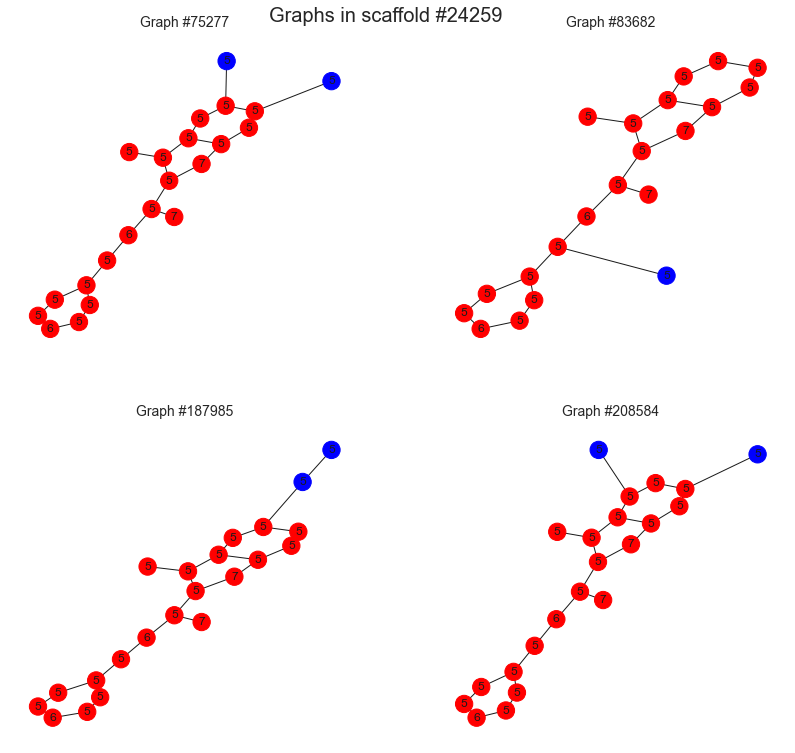

In [52]:
def reverse_dict(d):
    return {v: k for k, v in d.items()}

def parse_graph(graph_idx):
    edge_list = edge_index_array[:,edge_index_ranges[graph_idx]:edge_index_ranges[graph_idx+1]][:,::2].T
    g = nx.Graph([tuple(e) for e in edge_list])
    # set the node features
    x = x_array[node_index_ranges[graph_idx]:node_index_ranges[graph_idx+1],:]
    nx.set_node_attributes(g, {node: x[node, 0] for node in g}, 'attributes')
    # set the edge features (TODO later)
    nx.set_edge_attributes(g, [], "attributes")
    return g

def draw_graph(g, title=None, fontsize=16):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    nx.draw(g, pos=nx.spring_layout(g), ax=ax)
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    plt.show()

def draw_scaffold(g_array, sg, node_mapping_array, scaffold_idx, graph_idx_array, scaffold_x_array):
    ngraphs = len(g_array)
    fig, ax = plt.subplots((ngraphs+1)//2, 2, figsize=(14, 5*(ngraphs+1)//2))
    plt.subplots_adjust(top=0.95)
    fig.suptitle('Graphs in scaffold #{}'.format(scaffold_idx), fontsize=20)
    # find the node colors and the layouts
    color_map_array = []
    sg_pos = nx.spring_layout(sg, k=1/np.sqrt(len(sg))*10, iterations=1000, threshold=1e-6)
    pos_array = []
    for g, node_mapping in zip(g_array, node_mapping_array):
        color_map_array.append(['red' if node in node_mapping.values() else 'blue' for node in g])
        mapped_sg_pos = {node_mapping[n]: v for n, v in sg_pos.items()}
        pos = nx.spring_layout(g, pos=mapped_sg_pos, fixed=list(node_mapping.values()), iterations=1000, threshold=1e-5)
        pos_array.append(pos)
    # draw graphs
    for i, g in enumerate(g_array):
        nx.draw(g, node_color=color_map_array[i], pos=pos_array[i], ax=ax[i//2, i%2])
        nx.draw_networkx_labels(g, pos=pos_array[i], labels={node: scaffold_x_array[i][node, 0] for node in g}, 
                                ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title('Graph #{}'.format(graph_idx_array[i]), fontsize=14)
    if ngraphs%2 == 1:
        ax[-1, -1].axis('off')
    plt.show()


# find and parse the graphs in a scaffold
def analyze_scaffold(scaffold_idx):
    graph_idx_array = np.where(scaffold_array == scaffold_idx)[0]
    print('You are visualizing scaffold #{}.'.format(scaffold_idx))
    g_array = [parse_graph(idx) for idx in graph_idx_array]

    # if scaffold has at least two graphs
    if graph_idx_array.shape[0] >= 2:
        print('We have parsed {} graphs in scaffold #{}.'.format(graph_idx_array.shape[0], scaffold_idx))

        # find a pair of graphs first
        # for the ISMAGS algorithm to run fast, choose the largest and smallest graphs in the scaffold
        graph_size_array = np.array([len(g) for g in g_array])
        i1, i2 = np.argmax(graph_size_array), np.argmin(graph_size_array)
        g1, g2 = g_array[i1], g_array[i2]
        # find a largest common subgraph between them
        print('Working on finding the largest common subgraph between Graph #{} (size {}) and Graph #{} (size {}).'.format(
            graph_idx_array[i1], len(g1), graph_idx_array[i2], len(g2)))
        ismags = nx.isomorphism.ISMAGS(g1, g2)
        node_mapping = list(ismags.largest_common_subgraph(symmetry=True))[0]
        print('We find a largest common subgraph of size {}.'.format(len(node_mapping)))
        sg1 = g1.subgraph(list(node_mapping.keys()))
        sg2 = g2.subgraph(list(node_mapping.values()))
        sg = sg1
        # reducing the subgraph on other graphs
        print('Working on reducing the subgraph on other graphs in this scaffold')
        for i, g in enumerate(g_array):
            if i in [i1, i2]:
                continue
            if not GraphMatcher(g, sg).subgraph_is_isomorphic():
                print('Graph #{:6} doesn\'t contain the subgraph of size {}.'.format(graph_idx_array[i], len(sg)))
                print('Working on finding the largest common subgraph between Graph #{} (size {}) and the previous subgraph (size {}).'.format(
                    graph_idx_array[i], len(g), len(sg)))
                ismags = nx.isomorphism.ISMAGS(g, sg)
                node_mapping = list(ismags.largest_common_subgraph(symmetry=True))[0]
                print('Size of the largest common subgraph reduced to {}.'.format(len(node_mapping)))
                sg = sg.subgraph(list(node_mapping.values()))
            else:
                print('Graph #{:6} indeed contains the subgraph of size {}.'.format(graph_idx_array[i], len(sg)))
        print('We conclude the largest common subgraph of scaffold #{} has size {}.'.format(scaffold_idx, len(sg)))
        # find the node mappings
        node_mapping_array = [reverse_dict(list(GraphMatcher(g, sg).subgraph_isomorphisms_iter())[0]) for g in g_array]
        # select the node features
        scaffold_x_array = []
        for graph_idx in graph_idx_array:
            scaffold_x_array.append(x_array[node_index_ranges[graph_idx]:node_index_ranges[graph_idx+1],:])
        # draw the graphs in the scaffold
        draw_scaffold(g_array, sg, node_mapping_array, scaffold_idx, graph_idx_array, scaffold_x_array)

    # if only one graph in scaffold, just draw it
    else:
        print('There are only 1 graph in Scaffold #{}.'.format(scaffold_idx))
        draw_graph(g_array[0], title='Scaffold #{}\n Graph #{}'.format(scaffold_idx, graph_idxs[0]))


#analyze_scaffold(np.sort(sel_train_scaffold_idx)[501])
analyze_scaffold(24259)

You are visualizing scaffold #24370.
We have parsed 4 graphs in scaffold #24370.
Working on finding the largest common subgraph between Graph #144394 (size 21) and Graph #110505 (size 19).
We find a largest common subgraph of size 19.
Working on reducing the subgraph on other graphs in this scaffold
Graph # 72181 indeed contains the subgraph of size 19.
Graph #176511 indeed contains the subgraph of size 19.
We conclude the largest common subgraph of scaffold #24370 has size 19.


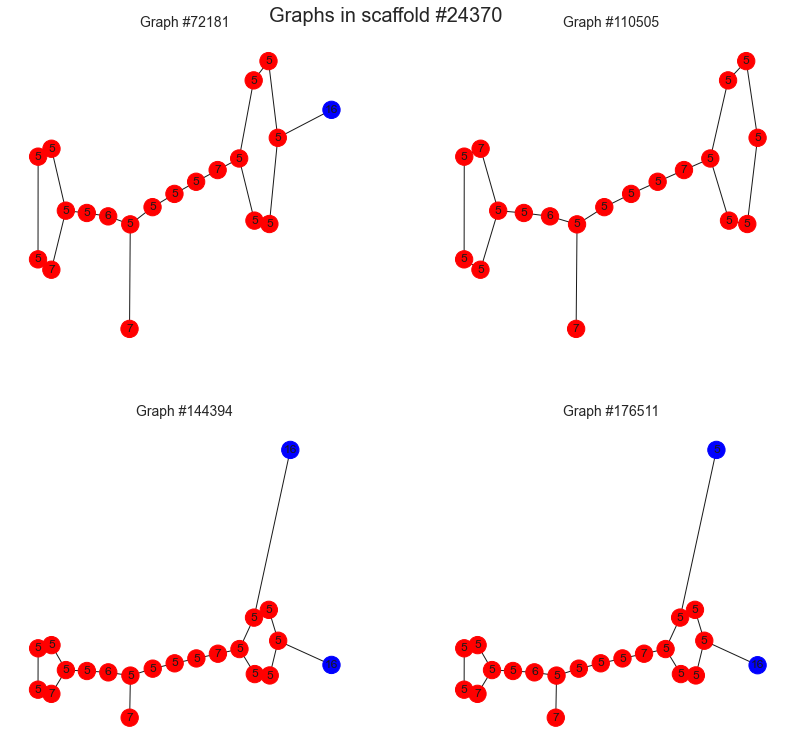

In [37]:
analyze_scaffold(np.sort(sel_train_scaffold_idx)[502])

## Statistics across Splits and Scaffolds

### Q6: What are the node feature distributions across (sampled) train/val/test splits and acorss scaffolds?

In [38]:
import seaborn as sns
sns.set_theme(style="white")
from sklearn.manifold import MDS
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, MultiscaleLaplacian, SubgraphMatching, VertexHistogram, RandomWalkLabeled

In [39]:
scaffold_idx_array = np.sort(sel_train_scaffold_idx)[500:510]
graph_idx_array = []
for scaffold_idx in scaffold_idx_array:
    graph_idx_array.append(np.where(scaffold_array == scaffold_idx)[0])
graph_idx_array = np.concatenate(graph_idx_array)
G_array = list(graph_from_networkx([parse_graph(idx) for idx in graph_idx_array], 
                                   node_labels_tag='attributes', edge_labels_tag='attributes'))
gk = RandomWalkLabeled(n_jobs=8)
sim_matrix = gk.fit_transform(G_array)

c:\users\mucong ding\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


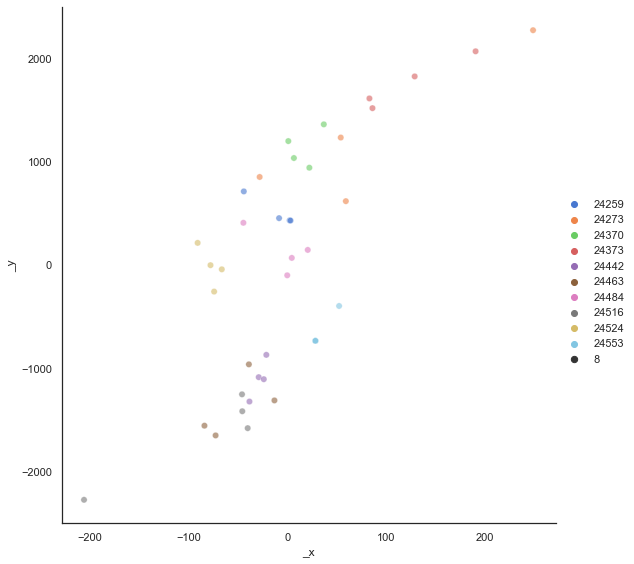

In [40]:
mds = MDS(n_components=2)
embedding = mds.fit_transform(sim_matrix)
# color map
color_map = [scaffold_array[graph_idx] for graph_idx in graph_idx_array]
sns.relplot(x=embedding[:,0], y=embedding[:,1], hue=color_map, size=8,
            sizes=(40, 400), alpha=.6, palette="muted", height=8)

In [41]:
scaffold_idx_array = np.sort(sel_train_scaffold_idx)[500:510]
graph_idx_array = []
for scaffold_idx in scaffold_idx_array:
    graph_idx_array.append(np.where(scaffold_array == scaffold_idx)[0])
graph_idx_array = np.concatenate(graph_idx_array)
G_array = list(graph_from_networkx([parse_graph(idx) for idx in graph_idx_array], 
                                   node_labels_tag='attributes', edge_labels_tag='attributes'))
gk = VertexHistogram(n_jobs=8)
sim_matrix = gk.fit_transform(G_array)

c:\users\mucong ding\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


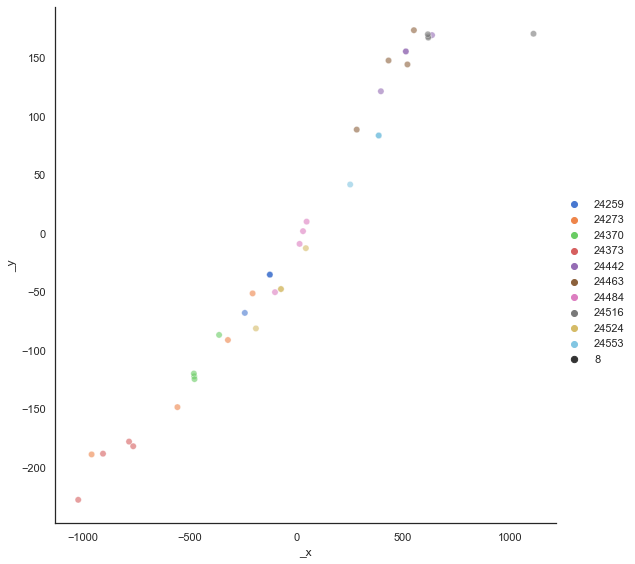

In [42]:
mds = MDS(n_components=2)
embedding = mds.fit_transform(sim_matrix)
# color map
color_map = [scaffold_array[graph_idx] for graph_idx in graph_idx_array]
sns.relplot(x=embedding[:,0], y=embedding[:,1], hue=color_map, size=8,
            sizes=(40, 400), alpha=.6, palette="muted", height=8)

You are visualizing scaffold #24463.
We have parsed 4 graphs in scaffold #24463.
Working on finding the largest common subgraph between Graph #69552 (size 33) and Graph #154336 (size 30).
We find a largest common subgraph of size 30.
Working on reducing the subgraph on other graphs in this scaffold
Graph #343357 indeed contains the subgraph of size 30.
Graph #424155 indeed contains the subgraph of size 30.
We conclude the largest common subgraph of scaffold #24463 has size 30.


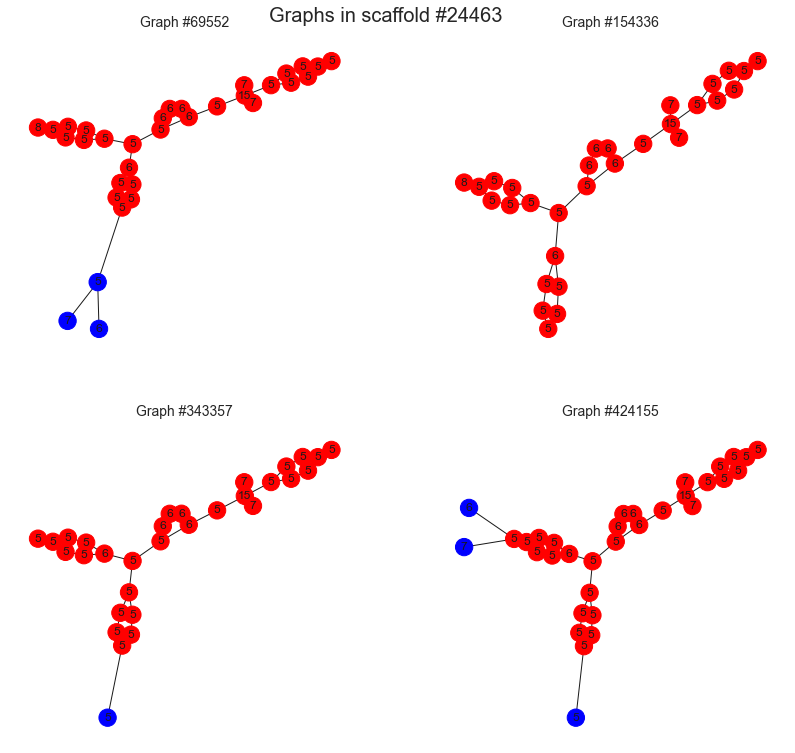

In [48]:
analyze_scaffold(24463)